# Topic Modeling for Customer Agent Conversation

In [1]:
!pip install pyLDAvis

In [4]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from pprint import pprint
import string
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('fin.csv', error_bad_lines=False)

C:\Users\tradi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 63671: expected 5 fields, saw 6\nSkipping line 66166: expected 5 fields, saw 6\n'


In [3]:
df

,conversationId,turnNumber,utteranceId,utterance,authorRole
0,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,0,acs-1757d840-5853-4752-b88d-d784e6ba5832,"Hello there, how may I help you today?",agent
1,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,1,acs-b9b6db75-b552-4704-a74f-d7c38b3c40c1,Hi....i need to check my balance,customer
2,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,2,acs-1539335e-cf44-4de9-b737-b2b347919fe9,"Sure thing, could you please help me out with ...",agent
3,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,3,acs-888ed142-16ad-466f-b2d5-66aec7095929,7766,customer
4,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,4,acs-96d4bda7-3de8-4eb6-a0d5-167e5d8684fe,Could you also please help me with your full n...,agent
...,...,...,...,...,...
157222,acs-23dbd0a0-9d49-4ffc-8c58-838fa2b3051d-1,15,acs-3b736bf2-edec-4cf1-ae76-1a822ee2d849,Sure! Please allow me a minute while I work on...,agent
157223,acs-23dbd0a0-9d49-4ffc-8c58-838fa2b3051d-1,16,acs-d85ef996-31ed-40e2-8d99-b54ec87ba518,OK,customer
157224,acs-23dbd0a0-9d49-4ffc-8c58-838fa2b3051d-1,17,acs-dffdb503-6844-41a1-8ae5-e7ed5b5b2f7a,Thanks for your patience. The transfer has bee...,agent
157225,acs-23dbd0a0-9d49-4ffc-8c58-838fa2b3051d-1,18,acs-3d081dde-a5d7-41cf-a46a-bcda9a7ee96c,OK THANK,customer


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157227 entries, 0 to 157226
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   conversationId  157227 non-null  object
 1   turnNumber      157227 non-null  int64 
 2   utteranceId     157227 non-null  object
 3   utterance       157227 non-null  object
 4   authorRole      157227 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.0+ MB


In [5]:
df1 = df.drop(['conversationId', 'turnNumber', 'utteranceId'], axis=1)

In [6]:
print(df1)

                                                utterance authorRole
0                  Hello there, how may I help you today?      agent
1                        Hi....i need to check my balance   customer
2       Sure thing, could you please help me out with ...      agent
3                                                    7766   customer
4       Could you also please help me with your full n...      agent
...                                                   ...        ...
157222  Sure! Please allow me a minute while I work on...      agent
157223                                                 OK   customer
157224  Thanks for your patience. The transfer has bee...      agent
157225                                          OK THANK    customer
157226  You're most welcome! Thank you for reaching ou...      agent

[157227 rows x 2 columns]


In [9]:
pd.set_option('display.max_colwidth', None)
df1

,utterance,authorRole
0,"Hello there, how may I help you today?",agent
1,Hi....i need to check my balance,customer
2,"Sure thing, could you please help me out with your full name and last 4 digits of your SSN?",agent
3,7766,customer
4,Could you also please help me with your full name?,agent
...,...,...
157222,Sure! Please allow me a minute while I work on your request.,agent
157223,OK,customer
157224,Thanks for your patience. The transfer has been successfully initiated. You’ll be receiving a confirmation e-mail shortly. Is there anything else I can do for you today?,agent
157225,OK THANK,customer


In [7]:
df1['authorRole'].value_counts()

customer    80682
agent       76545
Name: authorRole, dtype: int64

In [8]:
cust_df = df1[df1["authorRole"] == 'customer'] 

In [9]:
cust_df

,utterance,authorRole
1,Hi....i need to check my balance,customer
3,7766,customer
5,mani kumar,customer
7,7676,customer
10,ok sir,customer
...,...,...
157217,OK I NEED TRANSFER MONEY TO ANOTHER A/C,customer
157219,2597,customer
157221,250$,customer
157223,OK,customer


In [13]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80682 entries, 1 to 157225
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   utterance   80682 non-null  object
 1   authorRole  80682 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [10]:
agent_df = df1[df1["authorRole"] == 'agent'] 

In [11]:
agent_df

,utterance,authorRole
0,"Hello there, how may I help you today?",agent
2,"Sure thing, could you please help me out with ...",agent
4,Could you also please help me with your full n...,agent
6,Great! Could you please help me out with the l...,agent
8,Thank you for the details. Please allow me a m...,agent
...,...,...
157218,"Sure, please could you also share the account ...",agent
157220,Perfect! How much would you want to transfer?,agent
157222,Sure! Please allow me a minute while I work on...,agent
157224,Thanks for your patience. The transfer has bee...,agent


In [16]:
agent_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76545 entries, 0 to 157226
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   utterance   76545 non-null  object
 1   authorRole  76545 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


## Text processing for Agent data

In [ ]:
import re
def prepare(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|',text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text

In [ ]:
agent_df['utterance'] = agent_df['utterance'].apply(prepare)

In [14]:
agent_df.iloc[0,0]

'hello there how may i help you today '

In [15]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

In [16]:
# Tokenize text
agent_df['utterance'] = agent_df['utterance'].apply(lambda x: tokenizer.tokenize(x.lower()))

C:\Users\tradi\AppData\Local\Temp/ipykernel_55752/4131100412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agent_df['utterance'] = agent_df['utterance'].apply(lambda x: tokenizer.tokenize(x.lower()))


In [17]:
# import the needed library which contains the stopwords
from nltk.corpus import stopwords

In [18]:
# assign the stopwords to a variable stop
stop = set(stopwords.words('english'))

In [19]:
# a function to remove stop words from the data

def remove_stop(text):
    word = [w for w in text if w not in stop]
    return word

In [20]:
agent_df['utterance'] = agent_df['utterance'].apply(lambda x: remove_stop(x))

C:\Users\tradi\AppData\Local\Temp/ipykernel_55752/3472394140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agent_df['utterance'] = agent_df['utterance'].apply(lambda x: remove_stop(x))


In [21]:
# NLTK

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tradi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
# import the steming libraries to be used

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [23]:
# initialise the lemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    word = [lemmatizer.lemmatize(w) for w in text]
    return word

In [24]:
# Lemmatization

agent_df['utterance'] = agent_df['utterance'].apply(lambda x: lemmatize(x))

C:\Users\tradi\AppData\Local\Temp/ipykernel_55752/1838680537.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agent_df['utterance'] = agent_df['utterance'].apply(lambda x: lemmatize(x))


In [25]:
# 

porter = PorterStemmer()
def port(text):
    word_port = [porter.stem(i) for i in text]
    return word_port

In [26]:
agent_df['utterance'] = agent_df['utterance'].apply(lambda x: port(x))

C:\Users\tradi\AppData\Local\Temp/ipykernel_55752/3215755848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agent_df['utterance'] = agent_df['utterance'].apply(lambda x: port(x))


In [28]:
agent_df['utterance'] = agent_df['utterance'].astype('str')

C:\Users\tradi\AppData\Local\Temp/ipykernel_55752/3822698597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agent_df['utterance'] = agent_df['utterance'].astype('str')


In [2]:
#text_list=df1['utterance'].values.tolist()

## create document-term matrix using count vectorizer

In [29]:
from sklearn.feature_extraction.text import CountVectorizer 
#import lda

# create document term matrix
min_df = 4 # minimum required occurences of a word, e.g 4
max_features = 10000 # max number of unique words, e.g 10000

vectorizer = CountVectorizer(
              min_df=min_df, 
              max_features=max_features, 
              token_pattern='[a-zA-Z0-9]{3,}', # use tokenizer we defined before
              ngram_range=(2,3)) # we use unigram & bigram
X = vectorizer.fit_transform(agent_df['utterance'])


In [ ]:
## word cloud

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


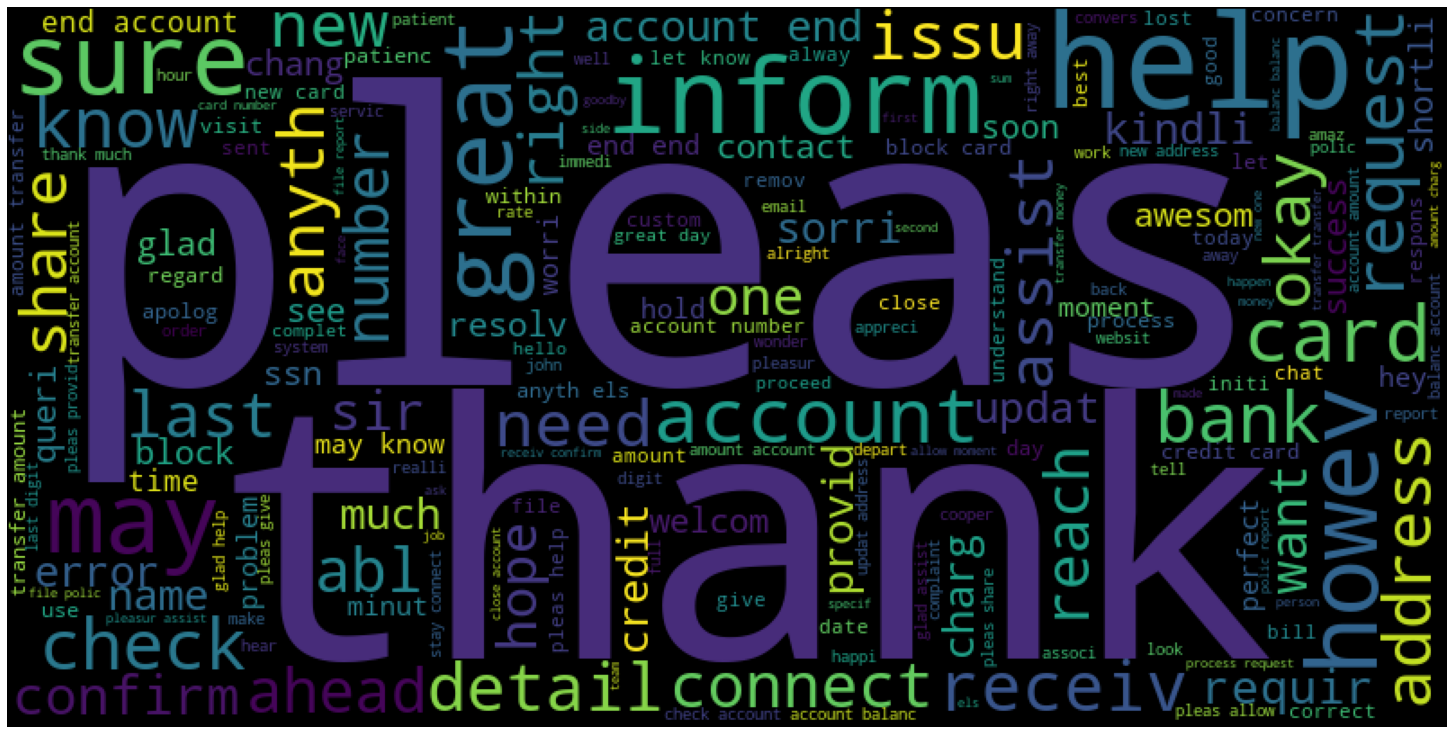

In [31]:
from wordcloud import WordCloud
for_wordcloud = vectorizer.get_feature_names()
for_wordcloud = for_wordcloud
for_wordcloud_str = ' '.join(for_wordcloud)

wordcloud = WordCloud(width=800, height=400, background_color ='black',
                      min_font_size = 7).generate(for_wordcloud_str)

plt.figure(figsize=(20, 10), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('agent_wc.jpg')
plt.show()

In [56]:
import seaborn as sns
sns.set_style('whitegrid')

## 10 common words in agents chat

In [59]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.figure(2, figsize=(10, 10/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.savefig('agent_top10.jpg')
    plt.show()

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tradi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


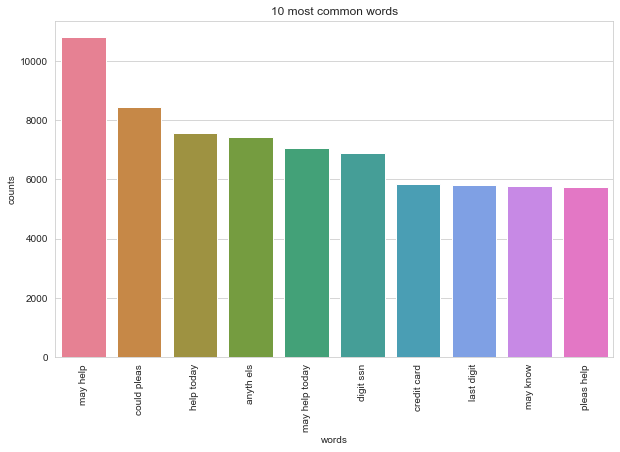

In [60]:
plot_10_most_common_words(X, vectorizer)

## Build LDA model

In [ ]:
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=50,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(X)

print(lda_model)  # Model attributes

#### for n_components = 10, max_iter=20
Log Likelihood:  -5801486.618063385
Perplexity:  438.71512179036466

## First run number of topics = 10, max_iter=50

In [39]:
# Log Likelyhood
print("Log Likelihood: ", lda_model.score(X))

# Perplexity: 
print("Perplexity: ", lda_model.perplexity(X))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -5277690.829825256
Perplexity:  500.510856400791
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 50,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [ ]:
Grid search
best model

In [61]:

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [62]:
# Print the topics found by the LDA model
print("Topics found via LDA for agents:")
print_topics(lda_model, vectorizer, 15)

Topics found via LDA:

Topic #0:
feel free pleas feel pleas feel free assist pleas free reach feel free reach good day day bye reach queri free reach queri good day bye queri good queri good day reach queri good time assist

Topic #1:
good morn pleas let pleas let know could pleas let let know could also pleas good morn may morn may also pleas help sure could could pleas morn may help sure could pleas hey good hey good morn

Topic #2:
account number digit account digit account number could also pleas help last digit account last digit help last four digit account pleas help last could pleas help last digit great could also pleas could pleas help

Topic #3:
hey may hey may help amount transfer thank wait wait patient thank wait patient confirm email sum amount sure glad sum amount transfer get confirm get confirm email within busi within busi day take hour

Topic #4:
could help four digit last four digit last four welcom anyth anyth els welcom anyth els digit ssn four digit ssn els coul

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Dominant topic in each document

In [41]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(X)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(agent_df['utterance']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_blue(val):
    color = 'blue' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_blue).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.850000,0.020000,0.020000,0.020000,6
Doc1,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.950000,9
Doc2,0.010000,0.010000,0.010000,0.420000,0.010000,0.010000,0.010000,0.010000,0.010000,0.500000,9
Doc3,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,2
Doc4,0.920000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0
Doc5,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,3
Doc6,0.020000,0.020000,0.020000,0.020000,0.520000,0.020000,0.020000,0.020000,0.020000,0.350000,4
Doc7,0.010000,0.010000,0.010000,0.430000,0.010000,0.010000,0.010000,0.010000,0.510000,0.010000,8
Doc8,0.020000,0.020000,0.020000,0.020000,0.520000,0.020000,0.020000,0.020000,0.020000,0.350000,4
Doc9,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.910000,0.010000,8


### topics distribution across documents

In [42]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,11127
1,6,10939
2,1,9176
3,9,8657
4,4,8194
5,2,6195
6,3,6062
7,8,5880
8,7,5345
9,5,4970


## LDA visualization

In [44]:
import sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, X, vectorizer, mds='tsne')
panel

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tradi\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'sq

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1      32.420952   8.115230       1        1  12.320401
9       0.648955  71.707100       2        1  11.981970
2      71.019684   9.971006       3        1  10.397557
4       3.785981  33.185135       4        1  10.262869
0     -42.666500  -9.222070       5        1   9.999001
3      -3.621689 -43.526516       6        1   9.590699
6      -3.632402  -4.171708       7        1   9.296630
8     -36.584400  35.804413       8        1   8.742788
5      44.391380  50.615383       9        1   8.722815
7      40.235809 -31.591665      10        1   8.685270, topic_info=                Term          Freq         Total Category  logprob  loglift
4771        may help  10445.000000  10445.000000  Default  30.0000  30.0000
903        anyth els   7292.000000   7292.000000  Default  29.0000  29.0000
3672      help today   7241.000000   7241.000000  Default  28.0000  28.0000
4772  may help today   6792.000000   6792.000000  Default  27.0000  27.0000
2997      four digit   5214.000000   5214.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
3019       full name    570.915643   1828.366652  Topic10  -4.8611   1.2796
4427      last digit    617.420924   5731.593837  Topic10  -4.7828   0.2153
4436  last digit ssn    587.919212   3187.470838  Topic10  -4.8318   0.7531
2617       digit ssn    588.213995   6768.634294  Topic10  -4.8313   0.0006
3293       great day    575.486909   5361.575017  Topic10  -4.8532   0.2117

[415 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
230       3  0.802002        account end
230       6  0.197866        account end
296       1  0.641055     account number
296       3  0.358881     account number
441      10  0.998688    address shortli
...     ...       ...                ...
8835      4  0.998194    would need last
8838      4  0.850961        would pleas
8838      8  0.148241        would pleas
8844      4  0.816622  would pleas share
8844      8  0.182842  would pleas share

[439 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 3, 5, 1, 4, 7, 9, 6, 8])

In [54]:
pyLDAvis.save_html(panel, 'lda_agent_topic10_50iter.html')

## Topic keywords

### Top 15 topic keywords

In [46]:
def get_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = get_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,pleas allow,card last,allow moment,last use,card last use,new address,pleas allow moment,date card,date card last,may know,thank could,thank could pleas,amount transfer,address updat,thank inform
Topic 1,may know,know name,account number,last digit,name pleas,may know name,let know,digit account,help may,know name pleas,know last,digit account number,last name,may pleas,pleas know
Topic 2,help last,account number,pleas help last,account end,digit account,digit account number,feel free,pleas feel,pleas feel free,pleas help,help last digit,assist pleas,last digit,great could,free reach
Topic 3,could also,hey may,hey may help,pleas could,like inform,could also pleas,would like,new one,also pleas,ssn number,thank reach,also pleas help,credit card,glad could,card number
Topic 4,anyth els,els may,anyth els may,els may help,may help,would anyth,would anyth els,welcom anyth,would pleas,welcom anyth els,would need,welcom would,welcom would anyth,els could,anyth els could
Topic 5,thank much,let know,thank use,chat servic,use live chat,use live,thank use live,live chat,live chat servic,great day,close chat,servic close,servic close chat,hesit let,hesit let know
Topic 6,may help,help today,may help today,hello may,hello may help,issu new,new card,block card,help date,great day,confirm messag,receiv confirm messag,talk great,talk great day,wonder talk
Topic 7,could pleas,credit card,pleas provid,card number,credit card number,could pleas provid,perfect could,complet credit card,complet credit,could pleas share,perfect could pleas,time patienc,ssn last,ssn last digit,digit ssn last
Topic 8,great day,credit card,card number,credit card number,digit credit,digit credit card,alway pleasur,day ahead,pleasur assist,custom like,great day ahead,alway pleasur assist,like great,custom like great,like great day
Topic 9,four digit,last four digit,last four,digit ssn,pleas help,four digit ssn,could pleas,could pleas help,know last four,good morn,may also,name last,also know,may also know,know last


## Second run number of topic=20, max_iter=50

In [36]:
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=50,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(X)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', max_iter=50,
                          n_components=20, n_jobs=-1, random_state=100)


In [37]:
# Log Likelyhood:
print("Log Likelihood: ", lda_model.score(X))

# Perplexity: 
print("Perplexity: ", lda_model.perplexity(X))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -4944918.4173037
Perplexity:  338.22703397946566
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 50,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### Dominant topic in each document

In [38]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(X)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(agent_df['utterance']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_blue(val):
    color = 'blue' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_blue).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.840000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,11
Doc1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.950000,19
Doc2,0.010000,0.210000,0.230000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.480000,19
Doc3,0.000000,0.000000,0.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
Doc4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.920000,0.000000,0.000000,0.000000,0.000000,15
Doc5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12
Doc6,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.510000,0.010000,0.010000,0.010000,0.340000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,8
Doc7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8
Doc8,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.510000,0.010000,0.010000,0.010000,0.340000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,8
Doc9,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.900000,0.010000,0.010000,0.010000,0.010000,0.010000,14


## topic distribution

In [39]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,11,7265
1,0,5964
2,19,4985
3,13,4841
4,8,4787
5,2,4691
6,12,4673
7,18,4035
8,5,3896
9,7,3483


In [40]:
import sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, X, vectorizer, mds='tsne')
panel

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tradi\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'sq

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
19     -10.878068   10.538728       1        1  7.822652
2      -60.884026  -75.591820       2        1  6.803264
18      -2.336119  -53.289074       3        1  6.704523
12     -61.385319  -12.914634       4        1  6.405010
13     -28.737743  126.296997       5        1  5.964602
17       1.066606 -123.552811       6        1  5.517216
0       45.140720   -7.947869       7        1  5.446271
14    -140.795975  -98.530548       8        1  5.351344
6       61.531681  -83.240562       9        1  4.916238
15     -72.563057 -140.396881      10        1  4.886216
8       15.984491   63.578186      11        1  4.839777
11    -160.851624   68.945145      12        1  4.679775
7       85.961830   51.922935      13        1  4.414736
4      -99.020836  109.936348      14        1  4.273356
1     -176.764130   -8.681684      15        1  3.856400
10    -117.189880  -37.420200      16        1  3.848047
5      108.829918  -22.946203      17        1  3.831309
3       47.588097  121.934814      18        1  3.736003
16    -106.467834   30.176889      19        1  3.408995
9      -50.613804   59.328842      20        1  3.294267, topic_info=                       Term          Freq         Total Category  logprob  \
4771               may help  10020.000000  10020.000000  Default  30.0000   
3672             help today   6807.000000   6807.000000  Default  29.0000   
4772         may help today   6368.000000   6368.000000  Default  28.0000   
903               anyth els   7296.000000   7296.000000  Default  27.0000   
2385            credit card   5830.000000   5830.000000  Default  26.0000   
...                     ...           ...           ...      ...      ...   
289            account like    185.370178    186.311710  Topic20  -5.0166   
290   account like transfer    183.346976    184.288508  Topic20  -5.0276   
2596     digit account like    180.385391    181.326924  Topic20  -5.0439   
5147            new address   1997.386456   2705.661589  Topic20  -2.6394   
2281             could help    599.515953   2766.243783  Topic20  -3.8428   

      loglift  
4771  30.0000  
3672  29.0000  
4772  28.0000  
903   27.0000  
2385  26.0000  
...       ...  
289    3.4079  
290    3.4079  
2596   3.4078  
5147   3.1095  
2281   1.8839  

[762 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
126      15  0.996681         abl assist
194       7  0.619745     account balanc
194      10  0.222842     account balanc
194      17  0.156322     account balanc
230       2  0.252926        account end
...     ...       ...                ...
8838      6  0.142840        would pleas
8838     14  0.585646        would pleas
8842      5  0.996498   would pleas help
8844      6  0.175727  would pleas share
8844     14  0.822670  would pleas share

[789 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 3, 19, 13, 14, 18, 1, 15, 7, 16, 9, 12, 8, 5, 2, 11, 6, 4, 17, 10])

In [41]:
pyLDAvis.save_html(panel, 'lda_agent_topic_20_50iter.html')

###  Topic-Keyword Matrix

In [42]:
# Topic-Keyword Matrix : weight matrix for all keywords in each topic.
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames


df_topic_keywords.head()

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000 account,000 account end,000 anyth,000 anyth els,000 would,000 would anyth,100 account,100 account end,100 check,100 success,...,www mybank,www mybank com,www willbank,www willbank com,yeah anyth,yeah anyth els,yeah sure,yeah sure could,yeah sure may,yeah sure pleas
Topic0,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.050000,0.05,0.05000,...,0.050000,0.050000,0.05,0.05,0.05,0.05,0.05,0.050000,0.05,0.050000
Topic1,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.050000,0.05,0.05000,...,5.965397,5.965397,0.05,0.05,0.05,0.05,0.05,5.472407,0.05,0.050000
Topic2,0.05,0.05,0.05,0.05,0.05,0.05,43.341179,25.956911,0.05,3.77706,...,0.050000,0.050000,0.05,0.05,0.05,0.05,0.05,0.050000,0.05,0.050000
Topic3,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.050000,0.05,0.05000,...,0.050000,0.050000,0.05,0.05,0.05,0.05,0.05,0.050000,0.05,4.052079
Topic4,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.050000,0.05,0.05000,...,0.050000,0.050000,0.05,0.05,0.05,0.05,0.05,0.050000,0.05,0.050000


In [43]:
def get_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = get_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,feel free,pleas feel,pleas feel free,assist pleas,feel free reach,free reach,good day,day bye,reach queri,free reach queri,good day bye,queri good,reach queri good,queri good day,time assist
Topic 1,good morn,pleas let,pleas let know,could pleas let,let know,could also pleas,good morn may,morn may,also pleas help,sure could,morn may help,hey good,could pleas,sure could pleas,hey good morn
Topic 2,account number,digit account,digit account number,could also,pleas help,last digit account,last digit,help last,four digit account,pleas help last,could pleas,help last digit,great could,also pleas,could pleas help
Topic 3,hey may,hey may help,amount transfer,thank wait,wait patient,thank wait patient,confirm email,sum amount,sure glad,sum amount transfer,get confirm,get confirm email,within busi day,within busi,take hour
Topic 4,could help,four digit,last four digit,last four,welcom anyth,anyth els,welcom anyth els,digit ssn,four digit ssn,els could,anyth els could,pleas share,share last,pleas share last,glad assist
Topic 5,give minut,pleas could,ssn number,kindli give,kindli give minut,number also,also ssn,number also ssn,also ssn number,thank pleas,could share,number ssn,thank pleas could,pleas could share,share account
Topic 6,great day,let know,thank use,thank use live,chat servic,live chat,live chat servic,use live,use live chat,talk great day,talk great,wonder talk,wonder talk great,close chat,file polic
Topic 7,great day,polic report,amount charg,report file,polic report file,time patienc,thank time,thank time patienc,date charg,allow minut,hope see,pleas allow minut,charg amount,charg amount charg,right away
Topic 8,anyth els,els may,anyth els may,els may help,may help,would anyth,would anyth els,welcom would,welcom would anyth,pleasur anyth,pleasur anyth els,updat address,kindli acknowledg,good news,okay file
Topic 9,new address,thank could,thank could pleas,help new,help new address,could help,need anyth,need anyth els,would need anyth,updat new,updat new address,pleas help new,thank could help,could help new,gone ahead


## Third Trial run Topic = 20, max_iter = 100

In [45]:
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=100,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(X)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', max_iter=100,
                          n_components=20, n_jobs=-1, random_state=100)


In [46]:
# Log Likelyhood
print("Log Likelihood: ", lda_model.score(X))

# Perplexity
print("Perplexity: ", lda_model.perplexity(X))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -4944603.957576722
Perplexity:  338.1017965651626
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 100,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [47]:
import sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, X, vectorizer, mds='tsne')
panel

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tradi\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\tradi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'sq

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
19     -10.878068   10.538728       1        1  7.822456
2      -60.884026  -75.591820       2        1  6.803202
18      -2.336119  -53.289074       3        1  6.704164
12     -61.385319  -12.914634       4        1  6.405208
13     -28.737743  126.296997       5        1  5.964642
17       1.066606 -123.552811       6        1  5.516729
0       45.140720   -7.947869       7        1  5.446276
14    -140.795975  -98.530548       8        1  5.351722
6       61.531681  -83.240562       9        1  4.918514
15     -72.563057 -140.396881      10        1  4.886357
8       15.984491   63.578186      11        1  4.839804
11    -160.851624   68.945145      12        1  4.679654
7       85.961830   51.922935      13        1  4.414621
4      -99.020836  109.936348      14        1  4.273576
1     -176.764130   -8.681684      15        1  3.856582
10    -117.189880  -37.420200      16        1  3.845907
5      108.829918  -22.946203      17        1  3.831194
3       47.588097  121.934814      18        1  3.735999
16    -106.467834   30.176889      19        1  3.409104
9      -50.613804   59.328842      20        1  3.294290, topic_info=                       Term          Freq         Total Category  logprob  \
4771               may help  10033.000000  10033.000000  Default  30.0000   
3672             help today   6825.000000   6825.000000  Default  29.0000   
4772         may help today   6380.000000   6380.000000  Default  28.0000   
903               anyth els   7299.000000   7299.000000  Default  27.0000   
2385            credit card   5825.000000   5825.000000  Default  26.0000   
...                     ...           ...           ...      ...      ...   
289            account like    186.071536    187.013470  Topic20  -5.0128   
290   account like transfer    184.035937    184.977870  Topic20  -5.0238   
2596     digit account like    181.028923    181.970856  Topic20  -5.0403   
5147            new address   1994.085120   2697.476128  Topic20  -2.6410   
2281             could help    597.969596   2761.028976  Topic20  -3.8454   

      loglift  
4771  30.0000  
3672  29.0000  
4772  28.0000  
903   27.0000  
2385  26.0000  
...       ...  
289    3.4079  
290    3.4079  
2596   3.4078  
5147   3.1108  
2281   1.8832  

[763 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
126      15  0.995721         abl assist
194       7  0.618412     account balanc
194      10  0.224078     account balanc
194      17  0.157075     account balanc
230       2  0.253639        account end
...     ...       ...                ...
8838      6  0.145605        would pleas
8838     14  0.585259        would pleas
8842      5  0.997971   would pleas help
8844      6  0.177566  would pleas share
8844     14  0.821244  would pleas share

[789 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 3, 19, 13, 14, 18, 1, 15, 7, 16, 9, 12, 8, 5, 2, 11, 6, 4, 17, 10])

In [48]:
pyLDAvis.save_html(panel, 'lda_agent_topic_20_iter100.html')

### Domi nant topic in each document

In [49]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(X)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(agent_df['utterance']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_blue(val):
    color = 'blue' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_blue).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.840000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,11
Doc1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.950000,19
Doc2,0.010000,0.210000,0.230000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.480000,19
Doc3,0.000000,0.000000,0.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
Doc4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.920000,0.000000,0.000000,0.000000,0.000000,15
Doc5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12
Doc6,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.510000,0.010000,0.010000,0.010000,0.340000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,8
Doc7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8
Doc8,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.510000,0.010000,0.010000,0.010000,0.340000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,8
Doc9,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.900000,0.010000,0.010000,0.010000,0.010000,0.010000,14


In [50]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,11,7265
1,0,5964
2,19,4985
3,13,4840
4,8,4787
5,2,4691
6,12,4673
7,18,4035
8,5,3896
9,7,3483


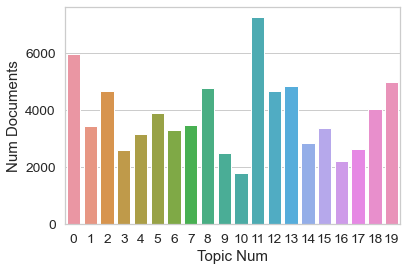

In [63]:
sns.barplot(x='Topic Num', y ='Num Documents',data=df_topic_distribution)
plt.savefig('dominant_topic_agent.jpg')

### Topic keyword weight matrix

In [51]:
# Topic-Keyword weight Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000 account,000 account end,000 anyth,000 anyth els,000 would,000 would anyth,100 account,100 account end,100 check,100 success,...,www mybank,www mybank com,www willbank,www willbank com,yeah anyth,yeah anyth els,yeah sure,yeah sure could,yeah sure may,yeah sure pleas
Topic0,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05000,0.05,0.050000,...,0.050000,0.050000,0.05,0.05,0.05,0.05,0.05,0.050000,0.05,0.050000
Topic1,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05000,0.05,0.050000,...,5.990935,5.990935,0.05,0.05,0.05,0.05,0.05,5.312274,0.05,0.050000
Topic2,0.05,0.05,0.05,0.05,0.05,0.05,43.220837,25.59694,0.05,3.875858,...,0.050000,0.050000,0.05,0.05,0.05,0.05,0.05,0.050000,0.05,0.050000
Topic3,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05000,0.05,0.050000,...,0.050000,0.050000,0.05,0.05,0.05,0.05,0.05,0.050000,0.05,4.053243
Topic4,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05000,0.05,0.050000,...,0.050000,0.050000,0.05,0.05,0.05,0.05,0.05,0.050000,0.05,0.050000


In [52]:
def get_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = get_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Users\tradi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,feel free,pleas feel,pleas feel free,assist pleas,free reach,feel free reach,good day,day bye,reach queri,free reach queri,good day bye,queri good day,queri good,reach queri good,time assist
Topic 1,good morn,pleas let,pleas let know,could pleas let,let know,could also pleas,morn may,good morn may,also pleas help,sure could,could pleas,morn may help,sure could pleas,hey good,hey good morn
Topic 2,account number,digit account,digit account number,could also,pleas help,last digit account,last digit,help last,four digit account,pleas help last,could pleas,help last digit,great could,also pleas,could pleas help
Topic 3,hey may,hey may help,amount transfer,thank wait,wait patient,thank wait patient,confirm email,sum amount,sure glad,sum amount transfer,get confirm,get confirm email,within busi day,within busi,take hour
Topic 4,could help,four digit,last four digit,last four,welcom anyth,anyth els,welcom anyth els,digit ssn,four digit ssn,els could,anyth els could,pleas share,share last,pleas share last,share last four
Topic 5,give minut,pleas could,ssn number,kindli give,kindli give minut,number also,also ssn,number also ssn,also ssn number,thank pleas,could share,number ssn,thank pleas could,pleas could share,share account
Topic 6,great day,let know,thank use,live chat,live chat servic,use live,use live chat,thank use live,chat servic,talk great,talk great day,wonder talk,wonder talk great,close chat,file polic
Topic 7,great day,polic report,amount charg,report file,polic report file,time patienc,thank time,thank time patienc,date charg,allow minut,hope see,pleas allow minut,charg amount,charg amount charg,right away
Topic 8,anyth els,els may,anyth els may,els may help,may help,would anyth,would anyth els,welcom would,welcom would anyth,pleasur anyth,pleasur anyth els,updat address,kindli acknowledg,good news,okay file
Topic 9,new address,thank could,thank could pleas,help new,help new address,could help,need anyth,need anyth els,would need anyth,updat new,updat new address,pleas help new,thank could help,could help new,gone ahead


In [53]:
df_topic_keywords.to_csv('agent_df_topic_keywords.csv', index=False)

In [54]:
df_topic__keyword_agent = pd.read_csv('agent_df_topic_keywords.csv')

In [55]:
df_topic__keyword_agent

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
0,feel free,pleas feel,pleas feel free,assist pleas,free reach,feel free reach,good day,day bye,reach queri,free reach queri,good day bye,queri good day,queri good,reach queri good,time assist
1,good morn,pleas let,pleas let know,could pleas let,let know,could also pleas,morn may,good morn may,also pleas help,sure could,could pleas,morn may help,sure could pleas,hey good,hey good morn
2,account number,digit account,digit account number,could also,pleas help,last digit account,last digit,help last,four digit account,pleas help last,could pleas,help last digit,great could,also pleas,could pleas help
3,hey may,hey may help,amount transfer,thank wait,wait patient,thank wait patient,confirm email,sum amount,sure glad,sum amount transfer,get confirm,get confirm email,within busi day,within busi,take hour
4,could help,four digit,last four digit,last four,welcom anyth,anyth els,welcom anyth els,digit ssn,four digit ssn,els could,anyth els could,pleas share,share last,pleas share last,share last four
5,give minut,pleas could,ssn number,kindli give,kindli give minut,number also,also ssn,number also ssn,also ssn number,thank pleas,could share,number ssn,thank pleas could,pleas could share,share account
6,great day,let know,thank use,live chat,live chat servic,use live,use live chat,thank use live,chat servic,talk great,talk great day,wonder talk,wonder talk great,close chat,file polic
7,great day,polic report,amount charg,report file,polic report file,time patienc,thank time,thank time patienc,date charg,allow minut,hope see,pleas allow minut,charg amount,charg amount charg,right away
8,anyth els,els may,anyth els may,els may help,may help,would anyth,would anyth els,welcom would,welcom would anyth,pleasur anyth,pleasur anyth els,updat address,kindli acknowledg,good news,okay file
9,new address,thank could,thank could pleas,help new,help new address,could help,need anyth,need anyth els,would need anyth,updat new,updat new address,pleas help new,thank could help,could help new,gone ahead
